In [10]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from pathlib import Path
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

from nltk.corpus import stopwords
import nltk


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
mallet_path = '../mallet-2.0.8/bin/mallet' # update this path

num_topics = 20

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])



In [2]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [3]:
import re
import numpy as np
import json

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def get_preprocessed_text(bookpath):
    preprocessed_sents = []
    preprocessed_sents_per_chapter = {}
    with open(bookpath) as book_json:
        chapter_par_dict = json.load(book_json)
        
        # for chapter, paragraphs in book
        for chapter, pars in chapter_par_dict.items():
            preprocessed_sents_per_chapter[chapter] = []
            
            # For actual paragraph in chapter
            for par in pars:
                sents = nltk.sent_tokenize(par)
                for sentence in sents:
                    sent = re.sub(r'\s+', ' ', sentence)  # remove newline chars
                    sent = re.sub(r'\"', '', sent)  # remove single quotes
                    sent = re.sub(r"\'", '', sent)  # remove single quotes
                    sent = re.sub(r"\*", '', sent)  # remove * in text
                    # Remove words that are smaller than given threshold (like J K R O W L I N G)
                    preprocessed_sents.append(sent)
                    preprocessed_sents_per_chapter[chapter].append(sent)
    return preprocessed_sents, preprocessed_sents_per_chapter

In [12]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def remove_shortwords(texts, wordlen_thresh=2):
    return [[word for word in doc if len(word.strip()) >= wordlen_thresh] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(nlp, texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
import matplotlib.pyplot as plt
bookPaths = Path('../data/books_json')
books = [book for book in bookPaths.iterdir() if 'book_' in book.name]

with open('../data/chapters/chapter_numbers.json') as chapter_numerated:
    chapter_numbers = json.load(chapter_numerated)

for book in books:
    print(f'==> Start Book {book.name}')
    book_compl, book_chapters = get_preprocessed_text(str(book))
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(book_chapters.values(), min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[book_chapters.values()], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    data_lemmatized = lemmatization(nlp, book_chapters.values())

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_lemmatized)
    data_wo_shortwords = remove_shortwords(data_words_nostops)
    #print(data_wo_shortwords)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_wo_shortwords, bigram_mod)
    #print(data_words_bigrams)
    # Do lemmatization keeping only noun, adj, vb, adv
    #data_lemmatized = lemmatization(nlp, data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_words_bigrams)

    # Create Corpus
    texts = data_wo_shortwords

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
#     # Continue from 16 on LDA website
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
    
    # Show Topics
 #   print(ldamallet.show_topics(formatted=True))
    df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=texts)

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
#    print(df_dominant_topic.head())
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

    # Show
    df_dominant_topic.to_csv(f'../data/topics/{book.name[:-5]}_gensim.csv')

==> Start Book book_2_coref.json
==> Start Book book_7_coref.json
==> Start Book book_3_coref.json
==> Start Book book_6_coref.json
==> Start Book book_4_coref.json
==> Start Book book_5_coref.json
==> Start Book book_1_coref.json


==> Start Book book_2_coref.json
 ---> Num Topics = 6  has Coherence Value of 0.2423
 ---> Num Topics = 8  has Coherence Value of 0.2624
 ---> Num Topics = 10  has Coherence Value of 0.2714
 ---> Num Topics = 12  has Coherence Value of 0.2714
 ---> Num Topics = 14  has Coherence Value of 0.3073
 ---> Num Topics = 16  has Coherence Value of 0.2852
 ---> Num Topics = 18  has Coherence Value of 0.3038
 ---> Num Topics = 20  has Coherence Value of 0.2844
 ---> Num Topics = 22  has Coherence Value of 0.2813
 ---> Num Topics = 24  has Coherence Value of 0.2892


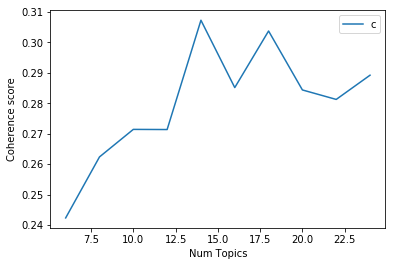

==> Start Book book_7_coref.json


KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt
bookPaths = Path('../data/books_json')
books = [book for book in bookPaths.iterdir() if 'book_' in book.name]

with open('../data/chapters/chapter_numbers.json') as chapter_numerated:
    chapter_numbers = json.load(chapter_numerated)

for book in books:
    print(f'==> Start Book {book.name}')
    book_compl, book_chapters = get_preprocessed_text(str(book))
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(book_chapters.values(), min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[book_chapters.values()], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    data_lemmatized = lemmatization(nlp, book_chapters.values())

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_lemmatized)
    data_wo_shortwords = remove_shortwords(data_words_nostops)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_wo_shortwords, bigram_mod)
    #print(data_words_bigrams)
    # Do lemmatization keeping only noun, adj, vb, adv
    #data_lemmatized = lemmatization(nlp, data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_words_bigrams)

    # Create Corpus
    texts = data_words_bigrams

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    start = 6
    limit = 26
    step = 2
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
    x = range(start, limit, step)
    for m, cv in zip(x, coherence_values):
        print(" ---> Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
    plt.figure()
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
#     # Continue from 16 on LDA website
#     ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
    
#     # Show Topics
#  #   print(ldamallet.show_topics(formatted=True))
#     df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=texts)

#     # Format
#     df_dominant_topic = df_topic_sents_keywords.reset_index()
# #    print(df_dominant_topic.head())
#     df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

#     # Show
#     df_dominant_topic.to_csv(f'../data/topics/{book.name[:-5]}_gensim.csv')

In [ ]:


# Can take a long time to run.



    # Show graph
    limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [14]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
    

Num Topics = 2  has Coherence Value of 0.2134
Num Topics = 8  has Coherence Value of 0.3351
Num Topics = 14  has Coherence Value of 0.3502
Num Topics = 20  has Coherence Value of 0.3699
Num Topics = 26  has Coherence Value of 0.3684
Num Topics = 32  has Coherence Value of 0.3548
Num Topics = 38  has Coherence Value of 0.3776


In [ ]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))